# ACTIVIDAD 3 (GRUPAL): REDES NEURONALES RECURRENTES (RNN)

---

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

Por sencillez, se adjunta un documento csv que es una versión resumida del dataset original del proyecto transversal. En este dataset, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [ ]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [ ]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [ ]:
data.shape

(12279, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Verás rápidamente que estamos en problemas: hay un gran desbalanceo.

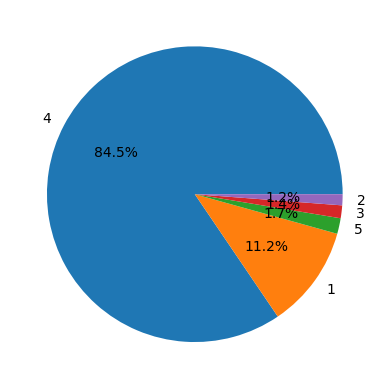

In [ ]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [ ]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [ ]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


Creamos los conjuntos de entrenamiento y de test:

In [ ]:
from tensorflow.keras.utils import to_categorical
X = data['mensaje']
y = data['intensidad']

# Dividimos el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertimos a numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values -1
y_test = y_test.values -1

# Convertir a one-hot-encoding
y_train_onehot = to_categorical(y_train, num_classes=5)
y_test_onehot = to_categorical(y_test, num_classes=5)

# Creamos datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_onehot))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_onehot))

Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy())
  print('nivel de odio: ', inte.numpy())

mensaje:  b'tarado abascal dice gran lider tarado trump'
nivel de odio:  [0. 0. 0. 1. 0.]


Mezclamos los datos de forma aleatoria:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy()[:3])
  print()
  print('nivel de odio: ', inte.numpy()[:3])

mensaje:  [b'pasa da pucherazos pone gobiernos t\xc3\xad\xc2\xadteres gente cabrea'
 b'tanta estupidez hoy dia creci viendo clasicos disney ninguno influyo volverme racista mentalidad ni\xc3\xb1o diferente adulto ridulez tan grande'
 b'bisonte gilipollas']

nivel de odio:  [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [ ]:
# Empezamos definiendo el tamaño del vocabulario
tamaño_vocabulario = 1000

# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(
    max_tokens=tamaño_vocabulario
)

# Se extraen solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)

In [ ]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras

array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'panfleto', 'q', 'españa', 'paí\xads', 'gente', 'vergüenza',
       'gentuza', 'vaya', 'basura', 'va', 'gilipollas', 'solo'],
      dtype='<U25')

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

**Tenéis plena liberta para realizar la red y para hacer cualquier modificación a los datos.**

In [ ]:
## Identificamos la longitud promedio de los mensajes
## Con esta información podemos entender el tamaño de la secuencia de nuestra red
## Y configurar los hiperparametros de acuerdo
def count_words(data):
  count = 0
  for line in data:
    words = line.split()
    count += len(words)
  return count

total_words = count_words(X)
print(total_words)

df = pd.DataFrame(X)

df['Avg_length'] = df["mensaje"].apply(lambda x: np.mean([len(w) for w in x.split()]))
df["Avg_length"].describe()

102260


,Avg_length
count,12279.000000
mean,6.784556
std,1.843188
min,1.000000
25%,5.736842
50%,6.571429
75%,7.500000
max,42.000000


In [ ]:
# Hiperparametros
vocab_size = 1000
sequence_length = 50
embedding_dim = 64
num_classes = 5

input_text = tf.keras.Input(shape=(), dtype=tf.string)

# Vectorización y embedding
x = vectorizador(input_text)
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x)

# LSTM + capas densas
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(5, activation='softmax')(x)

# Modelo
modelo = tf.keras.Model(inputs=input_text, outputs=output)

# Compilación
modelo.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

modelo.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_6            │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_12 (Embedding)        │ (None, None, 64)       │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,509 (396.52 KB)

 Trainable params: 101,509 (396.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
historial = modelo.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5
)
# Evaluación final
loss, acc = modelo.evaluate(test_dataset)
print(f"Precisión en test: {acc:.4f}")


Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8545 - loss: 0.5526 - val_accuracy: 0.8473 - val_loss: 0.5638
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8444 - loss: 0.5753 - val_accuracy: 0.8473 - val_loss: 0.5608
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.8395 - loss: 0.5824 - val_accuracy: 0.8473 - val_loss: 0.5585
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8430 - loss: 0.5764 - val_accuracy: 0.8461 - val_loss: 0.5629
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.8497 - loss: 0.5657 - val_accuracy: 0.8473 - val_loss: 0.5588
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8385 - loss: 0.5822
Precisión en test: 0.8473


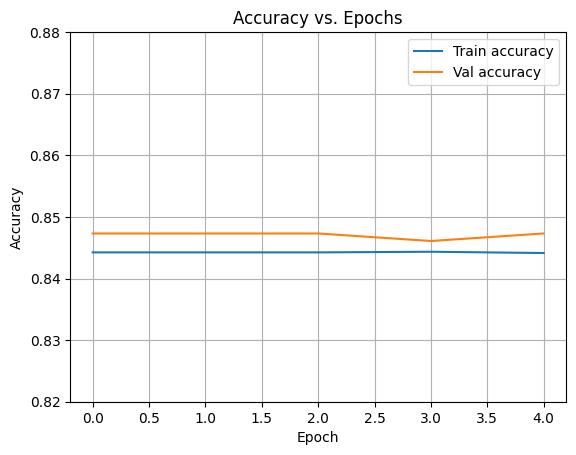

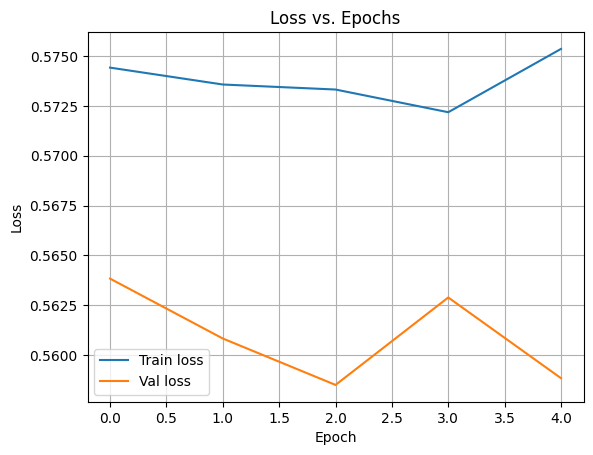

In [115]:
hist = historial.history

# 1 - Grafica Accuracy
plt.figure()
plt.plot(hist["accuracy"],     label="Train accuracy")
plt.plot(hist["val_accuracy"], label="Val accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.82, 0.88)
plt.legend()
plt.grid(True)
plt.show()

# 2 - Grafica Loss
plt.figure()
plt.plot(hist["loss"],     label="Train loss")
plt.plot(hist["val_loss"], label="Val loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       277
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        32
           3       0.85      1.00      0.92      2081
           4       0.00      0.00      0.00        41

    accuracy                           0.85      2456
   macro avg       0.17      0.20      0.18      2456
weighted avg       0.72      0.85      0.78      2456



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


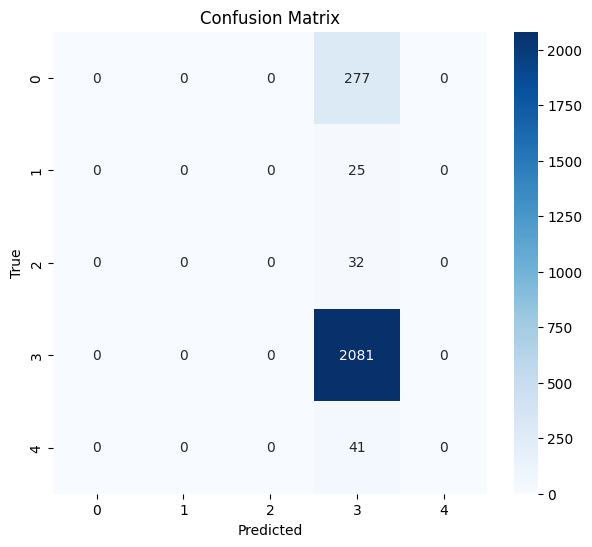

In [116]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
# Predecir etiquetas del test set
y_pred_prob = modelo.predict(test_dataset)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test  # recuerdas que ajustamos etiquetas de 1-5 a 0-4

print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted"), plt.ylabel("True")
plt.show()


In [132]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculamos pesos para manejar el desbalance de las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)


class_weights_dict = {i: w for i, w in enumerate(class_weights)}

# Construcción de una segunda red con pesos para evitar el desbalance de clases
# Adicionalmente modificamos la arquitectura para evitar overfitting
embedding_dim = 128

input_text = tf.keras.Input(shape=(), dtype=tf.string)

x = vectorizador(input_text)
x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(x)
x = layers.Bidirectional(layers.GRU(64, dropout=0.3))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(5, activation='softmax')(x)

modelo = tf.keras.Model(inputs=input_text, outputs=output)

In [133]:
modelo.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


historial = modelo.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 194ms/step - accuracy: 0.4939 - loss: 1.5623 - val_accuracy: 0.5985 - val_loss: 1.2701
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 191ms/step - accuracy: 0.5246 - loss: 1.4383 - val_accuracy: 0.5208 - val_loss: 1.1836
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 202ms/step - accuracy: 0.5586 - loss: 1.3074 - val_accuracy: 0.5330 - val_loss: 1.2703
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.6186 - loss: 1.0950 - val_accuracy: 0.5920 - val_loss: 1.0646
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 191ms/step - accuracy: 0.6271 - loss: 0.8922 - val_accuracy: 0.5843 - val_loss: 1.0263
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 31s 205ms/step - accuracy: 0.6621 - loss: 0.7670 - val_accuracy: 0.5639 - val_loss: 1.0658
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 40s 198ms/step - accuracy: 0.6691 - loss: 0.6558 - val_accuracy: 0.5733 - val_loss: 1.1029
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.6786 - loss: 0

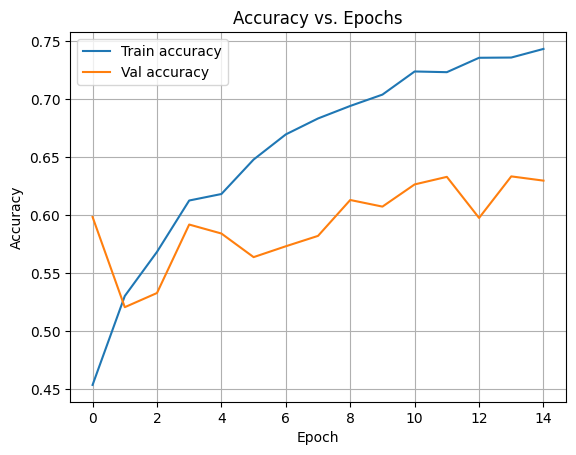

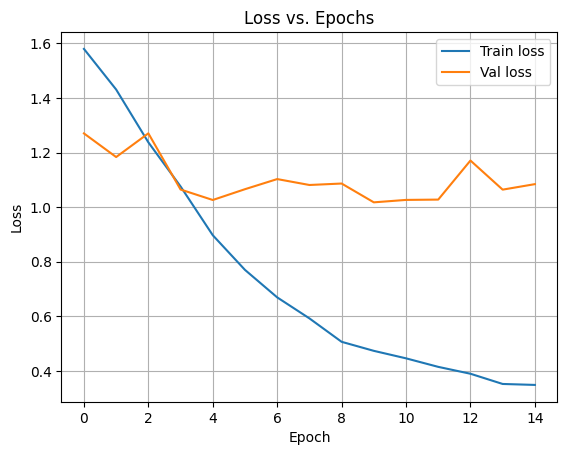

In [134]:
hist = historial.history

# 1 - Grafica Accuracy
plt.figure()
plt.plot(hist["accuracy"],     label="Train accuracy")
plt.plot(hist["val_accuracy"], label="Val accuracy")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 2 - Grafica Loss
plt.figure()
plt.plot(hist["loss"],     label="Train loss")
plt.plot(hist["val_loss"], label="Val loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.254     0.513     0.340       277
           1      0.060     0.400     0.104        25
           2      0.030     0.125     0.049        32
           3      0.946     0.635     0.760      2081
           4      0.070     0.341     0.117        41

    accuracy                          0.607      2456
   macro avg      0.272     0.403     0.274      2456
weighted avg      0.832     0.607     0.686      2456



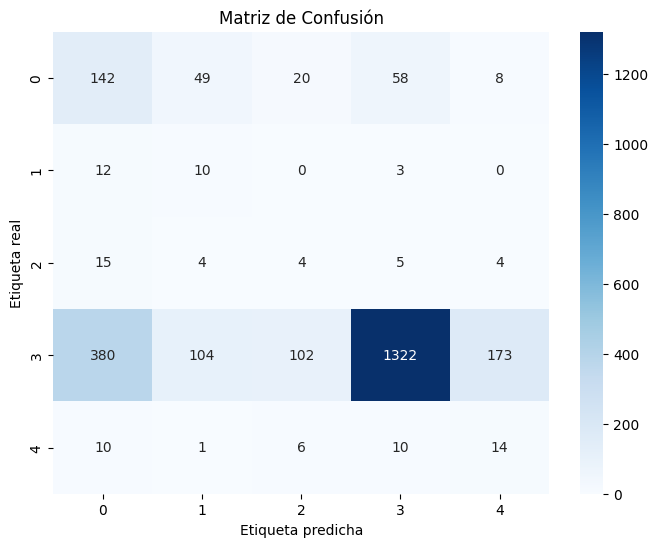

In [135]:
y_pred_probs = modelo.predict(test_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta real')
plt.title('Matriz de Confusión')
plt.show()